
# Testing Mask R-CNN Model

In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
#from sklearn.metrics import confusion_matrix

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "C:\\Breathing_Bag_Defect"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

WEIGHTS_PATH = "C:\\Breathing_Bag_Defect\\weights\\object20230506T0622\\mask_rcnn_object_0030.h5"   # change it


In [8]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Hole  # car and truck

    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels
    
    LEARNING_RATE = 0.001
    
    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50
    
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.001

    USE_MINI_MASK = False # True from start, try False to calc mAP see discord
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 2000

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5

In [9]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "Hole")
        #self.add_class("object", 2, "Discoloration")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open('C:\Breathing_Bag_Defect\Mask_RCNN\Dataset\\' + subset + '\\dataset.json'))

        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Hole": 1}  # Lägg komma efteråt följt av nästa klass vid flera
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [10]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "C:\\Breathing_Bag_Defect\\Mask_RCNN\\Dataset"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "C:\\Breathing_Bag_Defect\\Mask_RCNN\\Dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hole']
numids [1]
objects: ['Hol

In [11]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [12]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Breathing_Bag_Defect\weights\object20230506T0622\mask_rcnn_object_0030.h5
Re-starting from epoch 30


<span style="font-size: 24px; font-weight: bold;">Testing on selected image</span>


Images: 375
Classes: ['BG', 'Hole']
Processing 1 images
image                    shape: (3000, 3000, 3)       min:    0.00000  max:  226.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  106.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 3000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


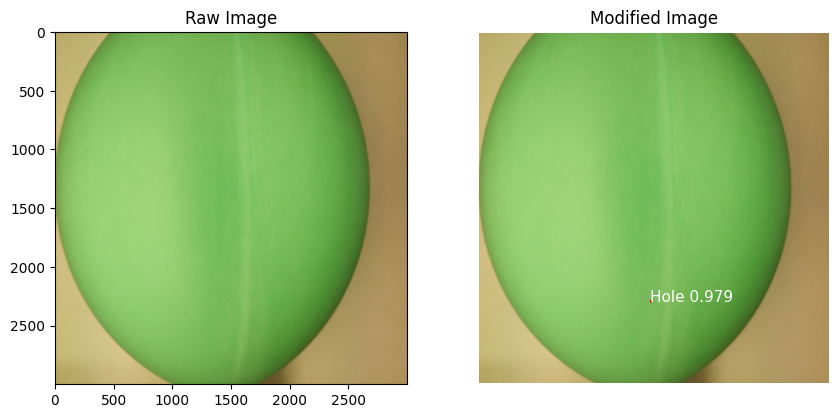

In [33]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Load the raw image
#C:\\Breathing_Bag_Defect\\Mask_RCNN\\Dataset\\Test\\IMG_3206.JPEG   # Test images
path_to_image = 'C:\\Breathing_Bag_Defect\\Mask_RCNN\\Dataset\\val\\im_12.jpg'

raw_image = mpimg.imread(path_to_image)

# Run object detection on the raw image
results = model.detect([raw_image], verbose=1)
r = results[0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the raw image in the left subplot
axs[0].imshow(raw_image)
axs[0].set_title('Raw Image')

# Display the modified image in the right subplot
visualize.display_instances(raw_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=axs[1])
axs[1].set_title('Modified Image')

# Show the figure
plt.show()

# Evaluation

In [22]:
def evaluate_model(dataset, model, cfg):

  APs = []
  for image_id in dataset.image_ids:
		
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id)
		
    scaled_image = modellib.mold_image(image, cfg)
		
    sample = np.expand_dims(scaled_image, 0)
		
    yhat = model.detect(sample, verbose=0)
		
    r = yhat[0]
		
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                          r["rois"], r["class_ids"], r["scores"], 
                                                          r['masks'], iou_threshold=0.5)
		
    APs.append(AP)

  mAP = np.mean(APs)
  return mAP
evaluate_model(dataset,model,config)

0.0